# COVID-19 in Mexico: Descriptive Visualizations

We show some general descriptive visualizations to understand in aggregate and state level the COVID-19 situation of Mexico.

In [1]:
import sys
sys.path.insert(1, './data/')
%load_ext autoreload
%autoreload 2
from covid_data import daily_covid, convert_to_state_date
#import get_data
#from state_preprocess import convert_to_state_date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import health_data



In [2]:
covid = daily_covid()

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory


## National Level Counts

In [3]:
#Get national counts of daily cases, hospitalizations and deaths.
start = covid.groupby(['fecha_ingreso', 'resultado']).size().unstack().reset_index()
start_2 = covid.groupby(['fecha_ingreso', 'hospitalizado']).size().unstack().reset_index()
death = covid.groupby(['fecha_def']).size().reset_index(name='deaths')
in_h = covid.groupby(['fecha_ingreso', 'hospitalizado']).size().unstack().reset_index()
in_h = in_h.rename(columns={1:'in_hospital', 'fecha_ingreso': 'date'}).drop(columns=[0]).reset_index()
national = start.rename(columns={'fecha_ingreso': 'date'}).merge(death.rename(columns={'fecha_def': 'date'}), 
                                                                  how='outer').merge(in_h, how='outer')
national.rename(columns={1:'positive', 2:'negative', 3:'pending'}, inplace=True)
national = national.merge(pd.DataFrame(pd.date_range('2020-01-01', periods=150, freq='D'), columns=['date']), how='right')

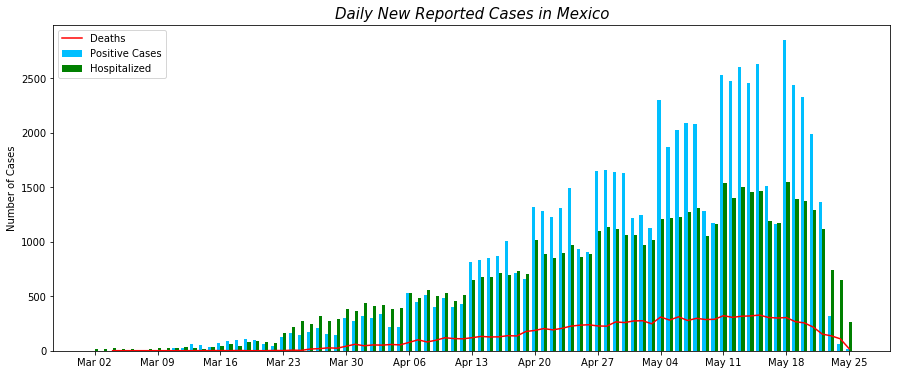

In [4]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,6))
sub = national[national.date > '2020-03-01']
width = 0.35 
plt.bar(sub.date, sub['positive'], -width, align="edge", label='Positive Cases', color='deepskyblue')
plt.bar(sub.date, sub['in_hospital'], +width, align="edge", label='Hospitalized', color='green')
sns.lineplot(x=sub.date, y=sub['deaths'],label='Deaths', color='red')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xlabel('')
plt.ylabel('Number of Cases')
plt.title('Daily New Reported Cases in Mexico', size=15, style='italic')
plt.legend(loc='upper left')
plt.show()

In [5]:
#Compute daily number of estimated recovered cases
recovered = covid.groupby(['fecha_rec', 'recovered']).size().reset_index(name='recovered_c').\
rename(columns={'fecha_rec':'date'})
recovered = recovered[recovered['recovered'] == 1]
recovered.drop(columns='recovered', inplace=True)
sub = sub.merge(recovered)

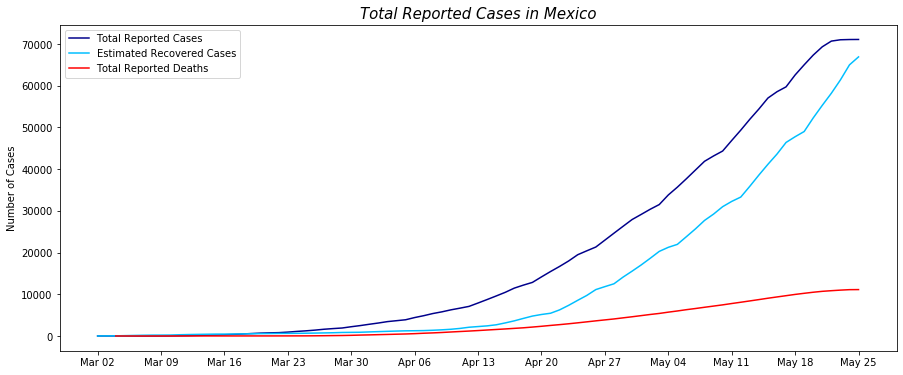

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=sub.date, y=sub.positive.cumsum(), color='darkblue', label='Total Reported Cases')
sns.lineplot(x=sub.date, y=sub.recovered_c.cumsum(), color='deepskyblue', label='Estimated Recovered Cases')
sns.lineplot(x=sub.date, y=sub.deaths.cumsum(), color='red', label='Total Reported Deaths')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xlabel('')
plt.ylabel('Number of Cases')
plt.title('Total Reported Cases in Mexico', size=15, style='italic')
plt.show()

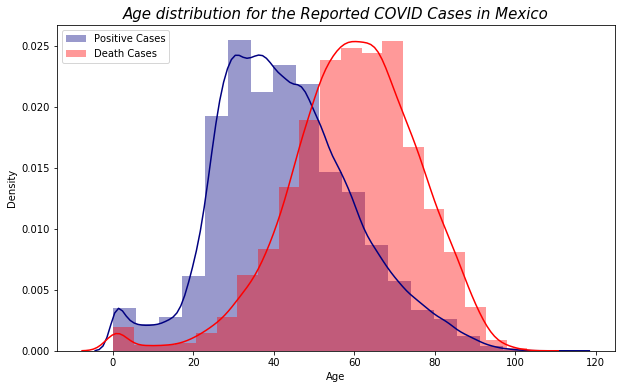

In [7]:
#Plot age distributions for the reported positive cases and deaths 
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(covid.edad, bins=20, kde=True, color='navy', label='Positive Cases')
sns.distplot(covid[covid.muertos == 1].edad, bins=20, kde=True, color='red', label='Death Cases')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age distribution for the Reported COVID Cases in Mexico', size=15, style='italic')
plt.legend(loc='upper left')
plt.show()

In [11]:
import geopandas as gpd
shape = gpd.read_file('data/mex_states_shape/mex_admbnda_adm1_govmex.shp')
states_shape = shape.loc[:,['ADM1_ES', 'ADM1_PCODE', 'geometry']]
states_shape.loc[:,'ADM1_PCODE'] = states_shape.ADM1_PCODE.apply(lambda row: 
                                                                 int(row.strip('MX')))
xls = 'data/description_catalogue_covid_mx.xlsx'
state_codes = pd.read_excel(xls, sheet_name='Catálogo de ENTIDADES')
covid_by_state = convert_to_state_date(True, covid, state_codes)

hdata = health_data.merge_data()

Finished cleaning, wrangling and grouping count columns are: ['casos_positivos', 'hospitalizado', 'muertos', 'intubado', 'neumonia', 'num_tests', 'habla_lengua_indig', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'otra_com', 'cardiovascular', 'obesidad', 'renal_cronica', 'tabaquismo', 'otro_caso', 'uci', 'Edad: (0, 10]', 'Edad: (10, 20]', 'Edad: (20, 30]', 'Edad: (30, 40]', 'Edad: (40, 50]', 'Edad: (50, 60]', 'Edad: (60, 70]', 'Edad: (70, 80]', 'Edad: (80, 90]', 'Edad: (90, 100]', 'Edad: (100, 110]', 'Edad: (110, 120]', 'entidad']


In [12]:
sum_bystate = covid_by_state.groupby(['entidad_um', 'entidad']).sum().reset_index()
sum_bystate.loc[:, 'poblacion'] = hdata['POB_MIT_AÑO']

sum_bystate.loc[:, 'positivos por 100000'] = (sum_bystate.casos_positivos/sum_bystate.poblacion) * 100000
sum_bystate.loc[:, 'muertos por 100000'] = (sum_bystate.muertos/sum_bystate.poblacion) * 100000
sum_bystate.loc[:, 'hospitalizado por 100000'] = (sum_bystate.hospitalizado/sum_bystate.poblacion) * 100000
sum_bystate.loc[:, 'pruebas por 100000'] = (sum_bystate.num_tests/sum_bystate.poblacion) * 100000



sum_bystate_gdf = states_shape.merge(sum_bystate, right_on='entidad_um', 
                                     left_on='ADM1_PCODE').loc[:,'geometry':]


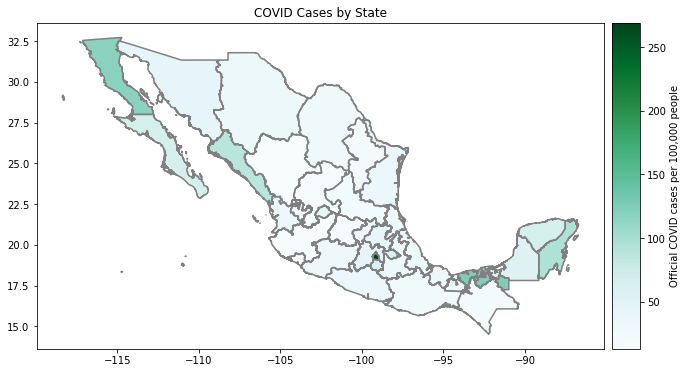

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("COVID Cases by State")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = sum_bystate_gdf.plot(column='positivos por 100000', cmap='BuGn', legend=True,
                          legend_kwds={'label': "Official COVID cases per 100,000 people"},
                          ax=ax, cax=cax)
sum_bystate_gdf.boundary.plot(color='grey',ax =ax);


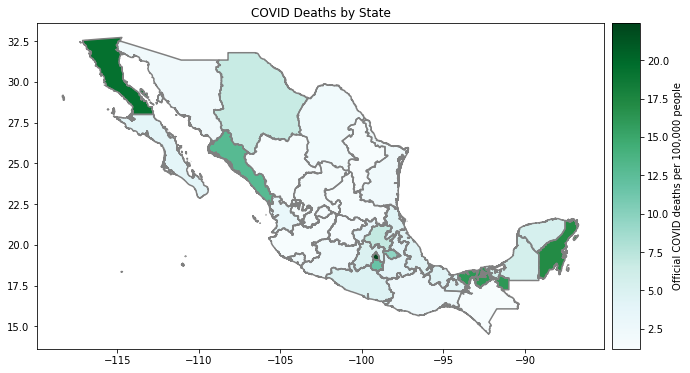

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("COVID Deaths by State")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = sum_bystate_gdf.plot(column='muertos por 100000', cmap='BuGn', legend=True,
                          legend_kwds={'label': "Official COVID deaths per 100,000 people"},
                          ax=ax, cax=cax)
sum_bystate_gdf.boundary.plot(color='grey',ax =ax);

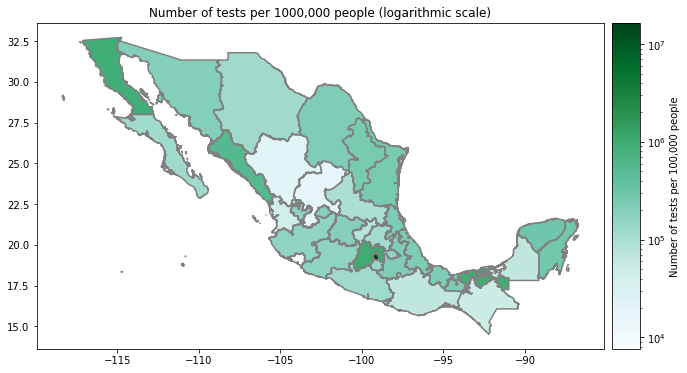

In [15]:
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Number of tests per 1000,000 people (logarithmic scale)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

divnorm = colors.LogNorm(vmin=min(sum_bystate['pruebas por 100000']), 
                         vmax=max(sum_bystate['pruebas por 100000']))

ax = sum_bystate_gdf.plot(column='pruebas por 100000', cmap='BuGn', legend=True, norm=divnorm,
                          legend_kwds={'label': "Number of tests per 100,000 people"},
                          ax=ax, cax=cax)
sum_bystate_gdf.boundary.plot(color='grey',ax =ax);

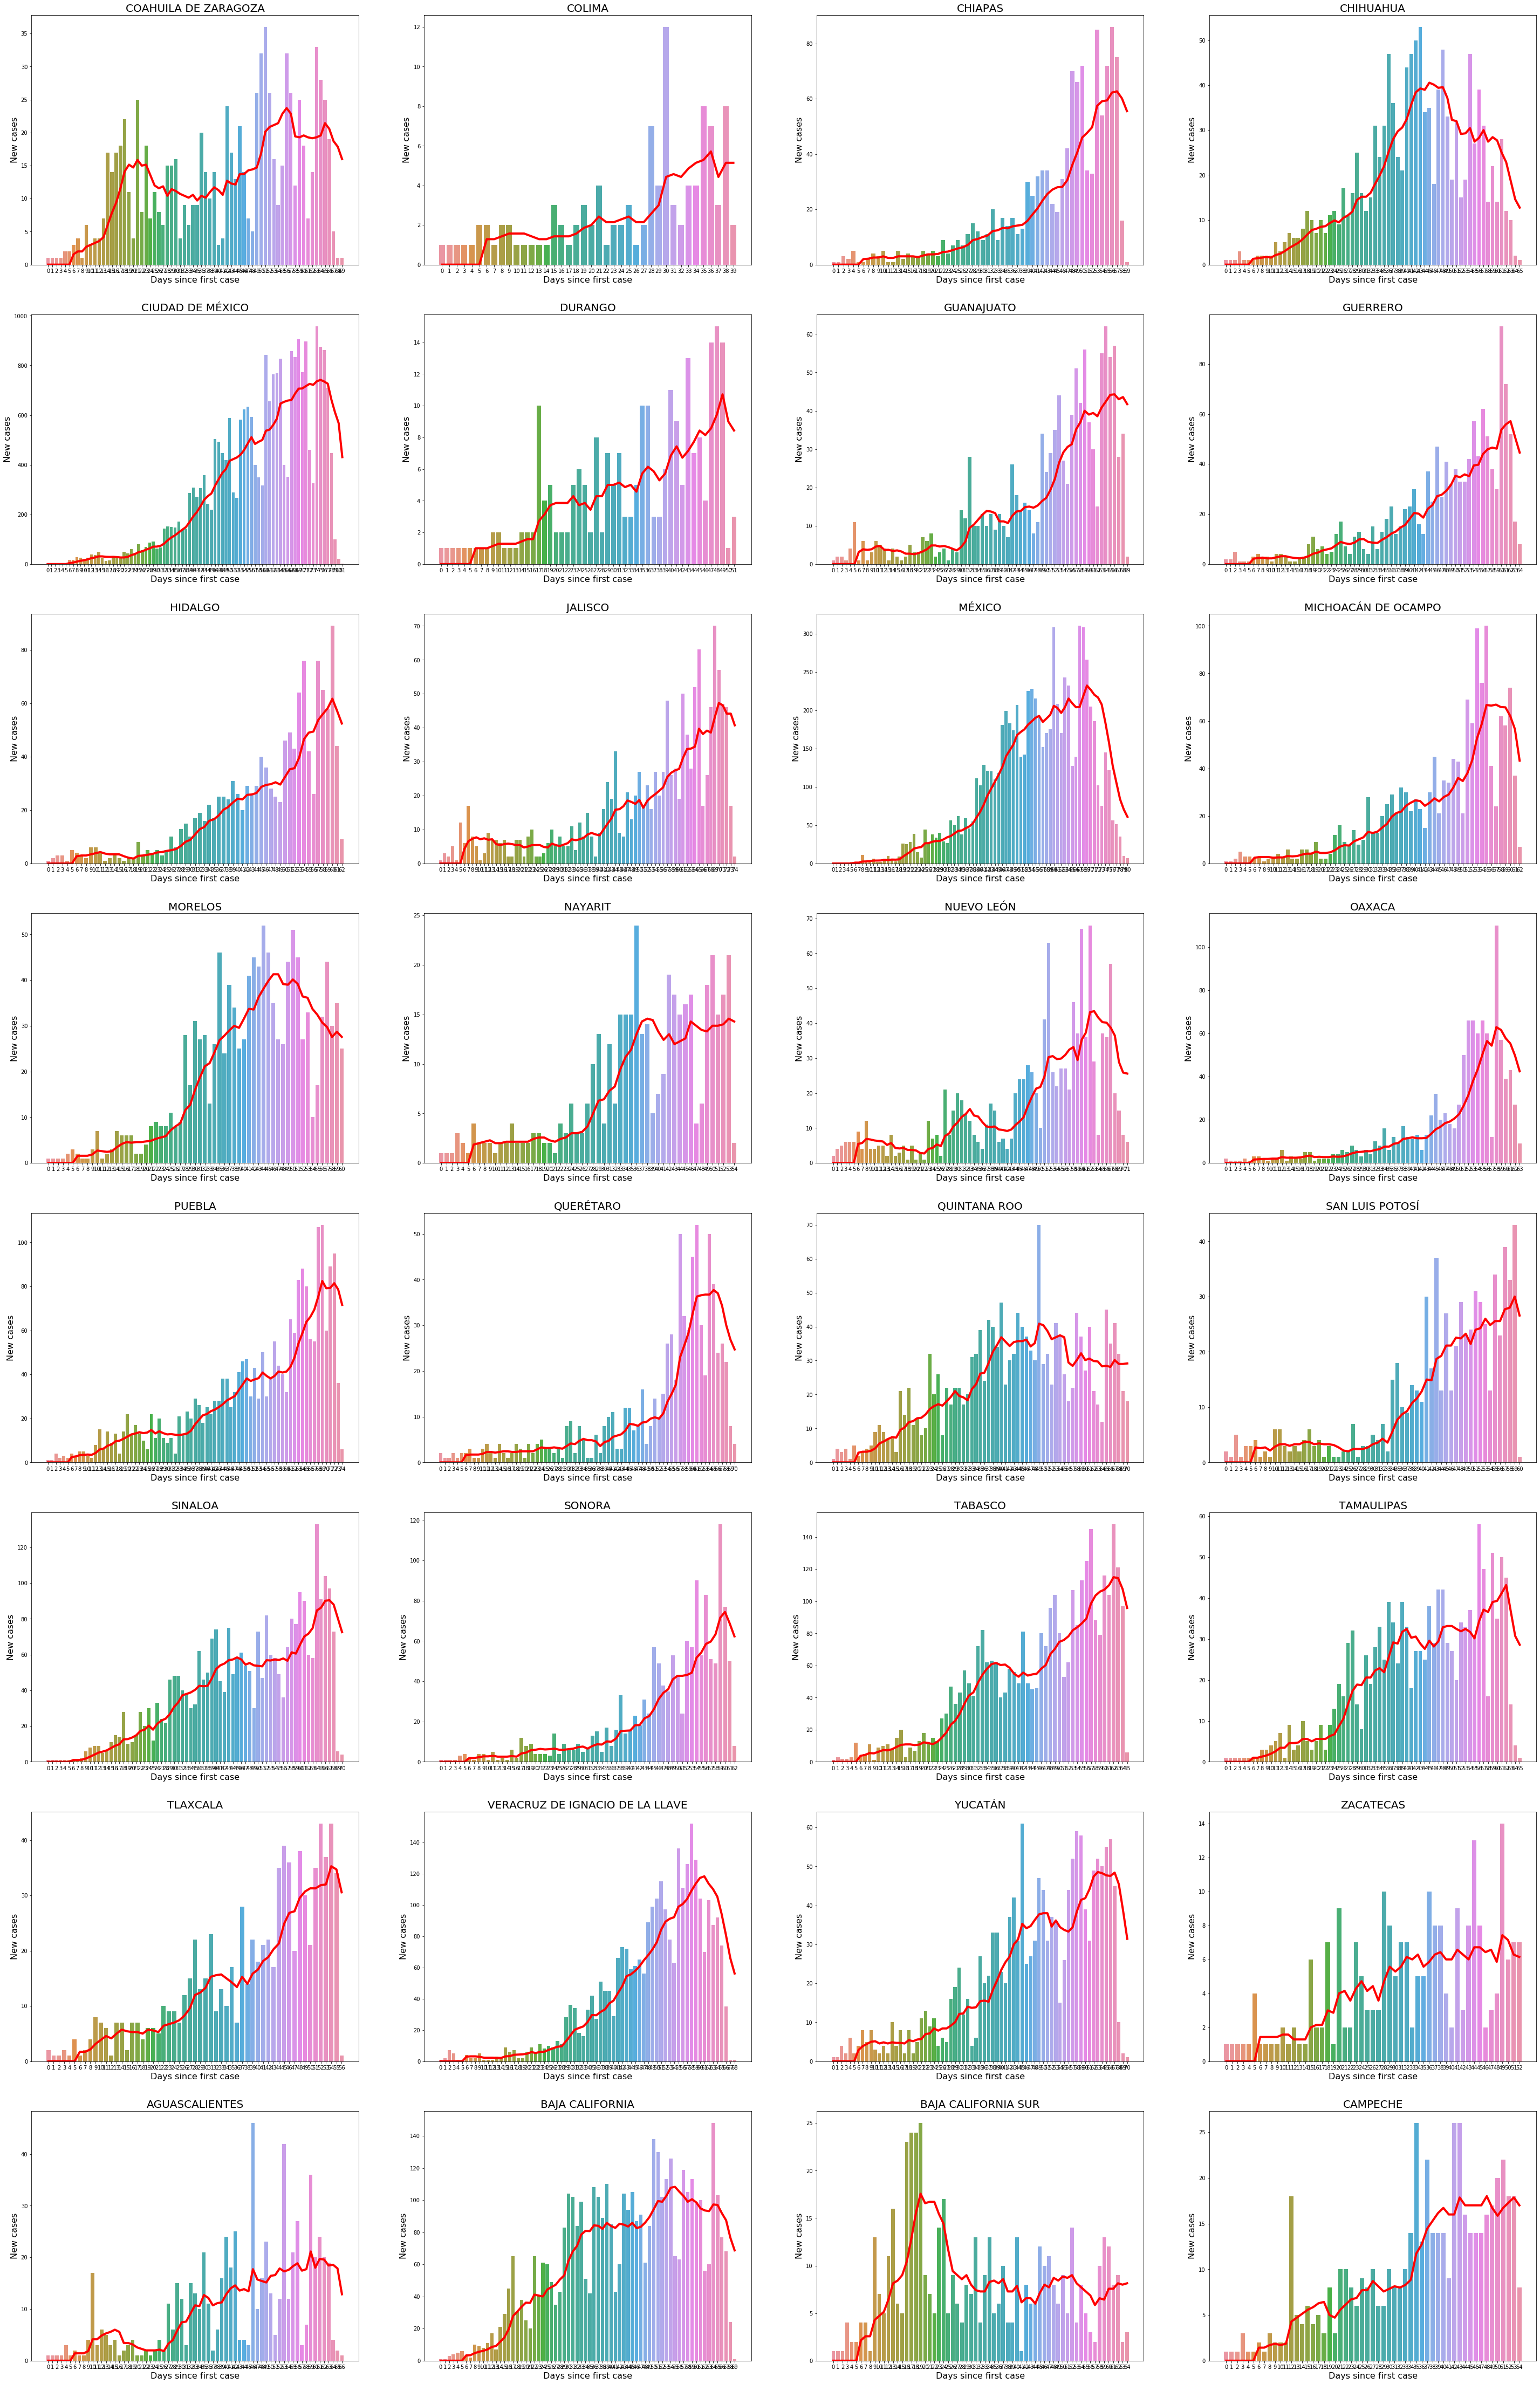

In [16]:
fig, ax = plt.subplots(8,4)
fig.set_size_inches(50, 80)

c = 0
r = -1
for i, st in enumerate(covid_by_state.entidad.unique()):
    plt.sca(ax[r, c])
    df = covid_by_state[covid_by_state.entidad == st]
    week_avg = df["casos_positivos"].rolling(window=7).mean()
    week_avg = week_avg.replace(np.nan, 0)
    #fechas = df['fecha_ingreso']
    x_vals = np.arange(0,df.shape[0])
    p = sns.barplot(x=x_vals, y="casos_positivos", data=df)
    sns.lineplot(x=x_vals, y=week_avg,
                 color = 'red',linewidth=4.0, ax=p)
    if c >= 3:
        c = 0
        r += 1
    else:
        c += 1
    p.set_title(st, fontsize=20)
    p.set_xlabel("Days since first case",fontsize=16)
    p.set_ylabel("New cases",fontsize=16)

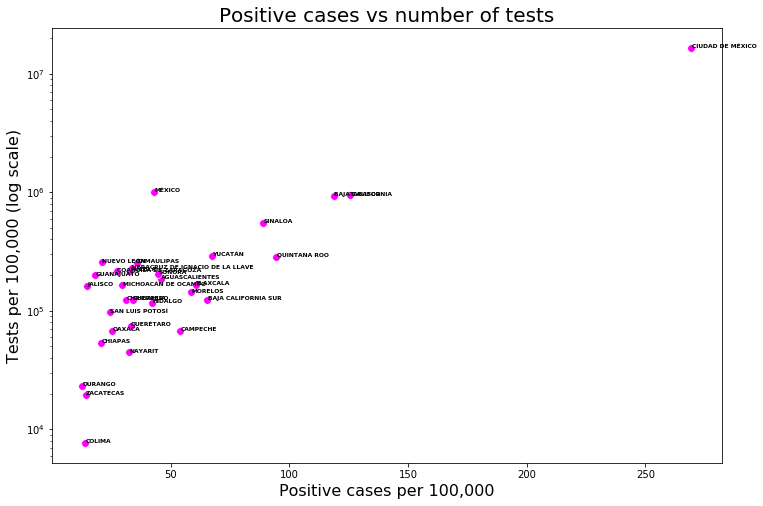

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.scatterplot(x='positivos por 100000', y='pruebas por 100000',
                    marker="o", color="magenta",s=60,
                    data=sum_bystate)
g.set_yscale("log")
g.set_ylabel("Tests per 100,000 (log scale)",fontsize=16)
g.set_xlabel("Positive cases per 100,000",fontsize=16)
g.set_title('Positive cases vs number of tests', fontsize=20)

for line in range(0,sum_bystate.shape[0]):
     g.text(sum_bystate['positivos por 100000'][line]+0.2, sum_bystate['pruebas por 100000'][line]+.3, 
             sum_bystate['entidad'][line], horizontalalignment='left', size=6, 
             color='black', weight='semibold')



In [19]:
print('''Average death rate of all states as of today {}'''.format(
     (sum_bystate['muertos por 100000']/sum_bystate['positivos por 100000']).mean()))

Average death rate of all states as of today 0.11090680385889065


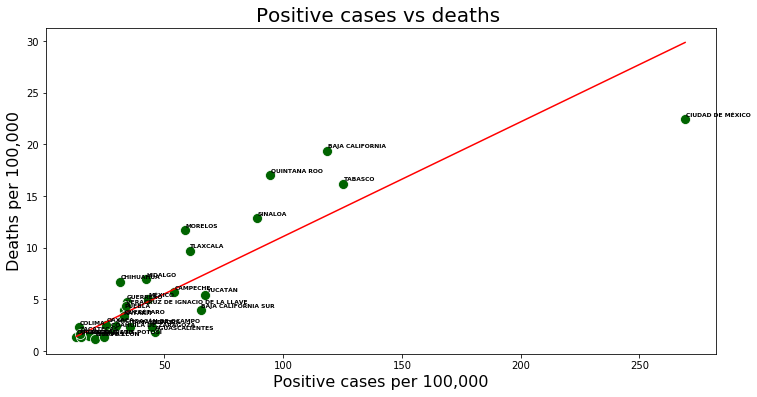

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
g = sns.scatterplot(x='positivos por 100000', y='muertos por 100000',
                    marker="o", color="darkgreen",s=100,
                    data=sum_bystate)

avgg = (sum_bystate['muertos por 100000']/sum_bystate['positivos por 100000']).mean()
sns.lineplot(x='positivos por 100000', y= sum_bystate['positivos por 100000']*avgg,
             data = sum_bystate, ax=g, color = 'red')

g.set_ylabel("Deaths per 100,000",fontsize=16)
g.set_xlabel("Positive cases per 100,000",fontsize=16)
g.set_title('Positive cases vs deaths ', fontsize=20)

for line in range(0,sum_bystate.shape[0]):
     g.text(sum_bystate['positivos por 100000'][line]+0.2, sum_bystate['muertos por 100000'][line]+.3, 
             sum_bystate['entidad'][line], horizontalalignment='left', size=6, 
             color='black', weight='semibold')

#### States above the line red line have a higher than average death rate, states below the red line have a lower than average death rate. (Average death rate for 32 states)

# Correlation matrix between select continuous variables and number of deaths and hospitalizations per state

In [21]:
state_health_df = sum_bystate.merge(hdata, left_on='entidad_um', right_on='CVE_GEO')

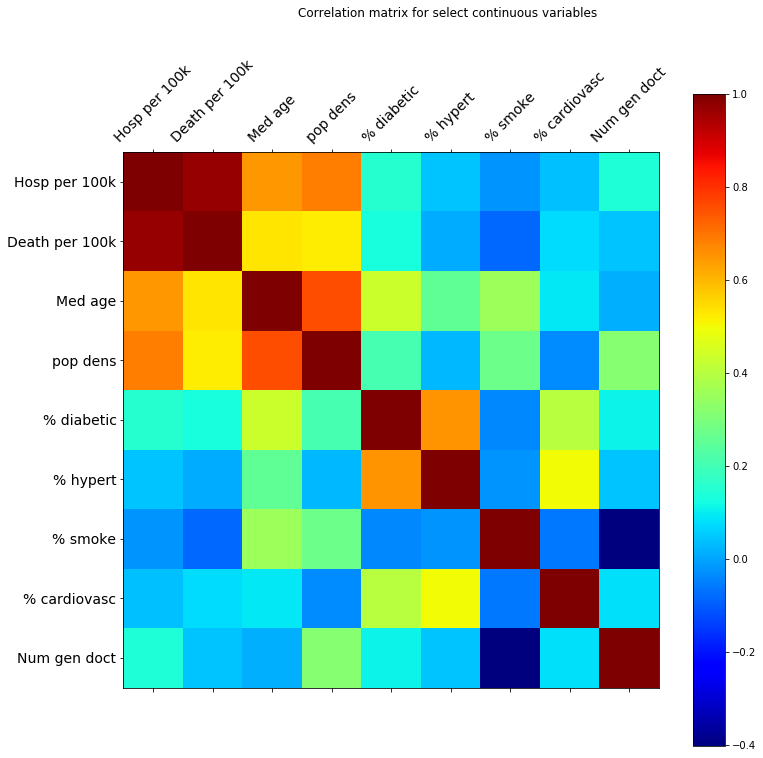

In [22]:
selected_vars = ['hospitalizado por 100000', 'muertos por 100000', 'EDAD_MED', 'Densidad_pob', 
                 'Porcentaje_Diabetes', 'Porcentaje_Hipertension', 'Porcentaje_Tabaquismo',
                 'Porcentaje_Cardiovascular','Número de Médicos Generales']
ticks = ['Hosp per 100k', 'Death per 100k', 'Med age', 
         'pop dens' ,'% diabetic','% hypert','% smoke', '% cardiovasc', 'Num gen doct']
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = fig.add_subplot(111)

cax = ax.matshow(state_health_df[selected_vars].corr(), cmap='jet')
fig.colorbar(cax)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_xticklabels(['']+ticks);
ax.set_yticklabels(['']+ticks);
plt.suptitle('Correlation matrix for select continuous variables');


In [23]:
hdata

,CVE_GEO,EDAD_MED,POB_MIT_AÑO,POB_12_14,POB_15_17,POB_15_19,POB_15_29,POB_15_49,POB_18_24,POB_20_24,...,Total de unidades de Hospitalizacion,Diabetes,Hipertension,Tabaquismo,POB_20_MAS_2018,Cardiovascular,Porcentaje_Diabetes,Porcentaje_Hipertension,Porcentaje_Tabaquismo,Porcentaje_Cardiovascular
0,1,27.00,1434635,80285,80698,133976,389147,774999,183623,130345,...,11,65487,126227,200182.0,858654,0.0,0.076267,0.147006,0.233135,0.000000
1,2,28.74,3634868,184400,186875,312423,949062,1999516,443050,317502,...,25,247659,516012,437796.0,2456298,2120.0,0.100826,0.210077,0.178234,0.000863
2,3,28.51,804708,40003,40181,67198,206768,445051,96038,69021,...,19,47555,93546,112282.0,565680,0.0,0.084067,0.165369,0.198490,0.000000
3,4,28.00,1000617,51364,50987,84871,258774,541300,119854,85970,...,22,88036,163436,76876.0,625996,635.0,0.140633,0.261082,0.122806,0.001014
4,5,28.00,3218720,167697,167040,277265,807595,1675574,380384,270159,...,47,253158,455245,454164.0,2032566,682.0,0.124551,0.223976,0.223444,0.000336
5,6,28.86,785153,39648,39611,65932,198757,420848,92384,66063,...,12,57121,89882,105547.0,521874,0.0,0.109454,0.172229,0.202246,0.000000
6,7,24.00,5730367,349429,334902,547589,1526179,2947906,716702,504015,...,64,258875,537685,360700.0,3312336,3260.0,0.078155,0.162328,0.108896,0.000984
7,8,28.07,3801487,203047,203271,336882,976498,2013392,459199,325588,...,40,235428,569330,629253.0,2518914,4753.0,0.093464,0.226022,0.249811,0.001887
8,9,35.00,9018645,357583,376260,637120,2065188,4809629,949655,688795,...,105,855886,1333372,1550087.0,6598410,6450.0,0.129711,0.202075,0.234918,0.000978
9,10,27.00,1868996,104852,102696,169281,484086,970721,227592,161007,...,36,129468,237641,231187.0,1173551,1508.0,0.110322,0.202497,0.196998,0.001285


# Health Data

In [24]:
# get health data
hdata = health_data.merge_data()

# add state names to ids
state_names = covid_by_state[['entidad_um', 'entidad']].groupby('entidad').mean().reset_index()
hdata = hdata.merge(state_names, left_on='CVE_GEO', right_on='entidad_um', how='inner')
hdata.drop(columns=['entidad_um'], inplace=True)

# add beds per capita
hdata['hb_pop1000'] = hdata['TOTAL CAMAS AREA HOSPITALIZACIÓN'] / hdata['POB_MIT_AÑO'] * 1000
hdata['pop_65'] = hdata['POB_65_MAS'] / hdata['POB_MIT_AÑO']

hdata.head()

,CVE_GEO,EDAD_MED,POB_MIT_AÑO,POB_12_14,POB_15_17,POB_15_19,POB_15_29,POB_15_49,POB_18_24,POB_20_24,...,Tabaquismo,POB_20_MAS_2018,Cardiovascular,Porcentaje_Diabetes,Porcentaje_Hipertension,Porcentaje_Tabaquismo,Porcentaje_Cardiovascular,entidad,hb_pop1000,pop_65
0,1,27.00,1434635,80285,80698,133976,389147,774999,183623,130345,...,200182.0,858654,0.0,0.076267,0.147006,0.233135,0.000000,AGUASCALIENTES,0.673342,0.064081
1,2,28.74,3634868,184400,186875,312423,949062,1999516,443050,317502,...,437796.0,2456298,2120.0,0.100826,0.210077,0.178234,0.000863,BAJA CALIFORNIA,0.573611,0.063688
2,3,28.51,804708,40003,40181,67198,206768,445051,96038,69021,...,112282.0,565680,0.0,0.084067,0.165369,0.198490,0.000000,BAJA CALIFORNIA SUR,0.838814,0.060849
3,4,28.00,1000617,51364,50987,84871,258774,541300,119854,85970,...,76876.0,625996,635.0,0.140633,0.261082,0.122806,0.001014,CAMPECHE,0.763529,0.067711
4,5,28.00,3218720,167697,167040,277265,807595,1675574,380384,270159,...,454164.0,2032566,682.0,0.124551,0.223976,0.223444,0.000336,COAHUILA DE ZARAGOZA,0.892902,0.071377


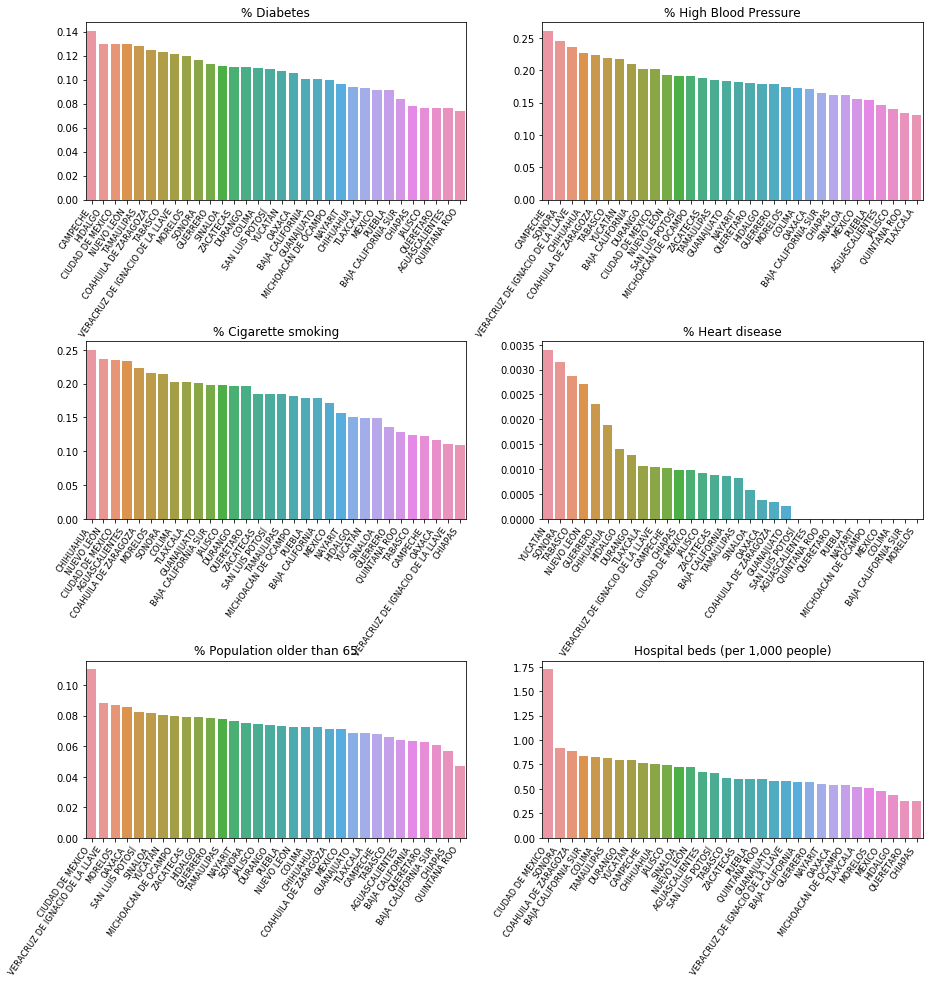

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
cols = ['Porcentaje_Diabetes', 'Porcentaje_Hipertension', 'Porcentaje_Tabaquismo', 
        'Porcentaje_Cardiovascular', 'pop_65', 'hb_pop1000']
titles = ["% Diabetes", "% High Blood Pressure", "% Cigarette smoking", "% Heart disease", 
          '% Population older than 65','Hospital beds (per 1,000 people)']

i = 0
for x in range(0,3):
    for y in range(0,2):
        
        sns.barplot(x="entidad", y=cols[i] , ax=ax[x, y], data=hdata.sort_values(by=cols[i], ascending=False))
        ax[x, y].set_title(titles[i])
        ax[x, y].set_xticklabels(ax[x, y].get_xticklabels(), rotation=55, 
                                 horizontalalignment='right', fontsize='small')
        ax[x, y].set_ylabel('')
        ax[x, y].set_ylabel('')    
        ax[x, y].set_xlabel('')
        i += 1

plt.subplots_adjust(hspace = 0.8)
plt.show();

# ML Model

In [31]:
import mlpipeline as pipeline

In [32]:
# separate features to use in the model

features_covid = ['municipio_res', 'embarazo', 'edad', 'diabetes', 'epoc', 
                  'asma', 'inmusupr', 'hipertension', 'cardiovascular', 'obesidad', 'tabaquismo', 'muertos']
data_model = covid[features_covid]
print(data_model.shape)
data_model.head()

(225650, 12)


,municipio_res,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,cardiovascular,obesidad,tabaquismo,muertos
0,7,0.0,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,120,0.0,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,91,0.0,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,20,0.0,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2,0.0,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [33]:
# how many missing values do we have?
pipeline.count_nan(data_model)

municipio_res     0
embarazo          0
edad              0
diabetes          0
epoc              0
asma              0
inmusupr          0
hipertension      0
cardiovascular    0
obesidad          0
tabaquismo        0
muertos           0
dtype: int64

In [34]:
#split training and testing data 

train, test = pipeline.split_data(data_model, 0.2)
print('test obs:', test.shape[0])
print('train obs:', train.shape[0])

test obs: 45130
train obs: 180520
